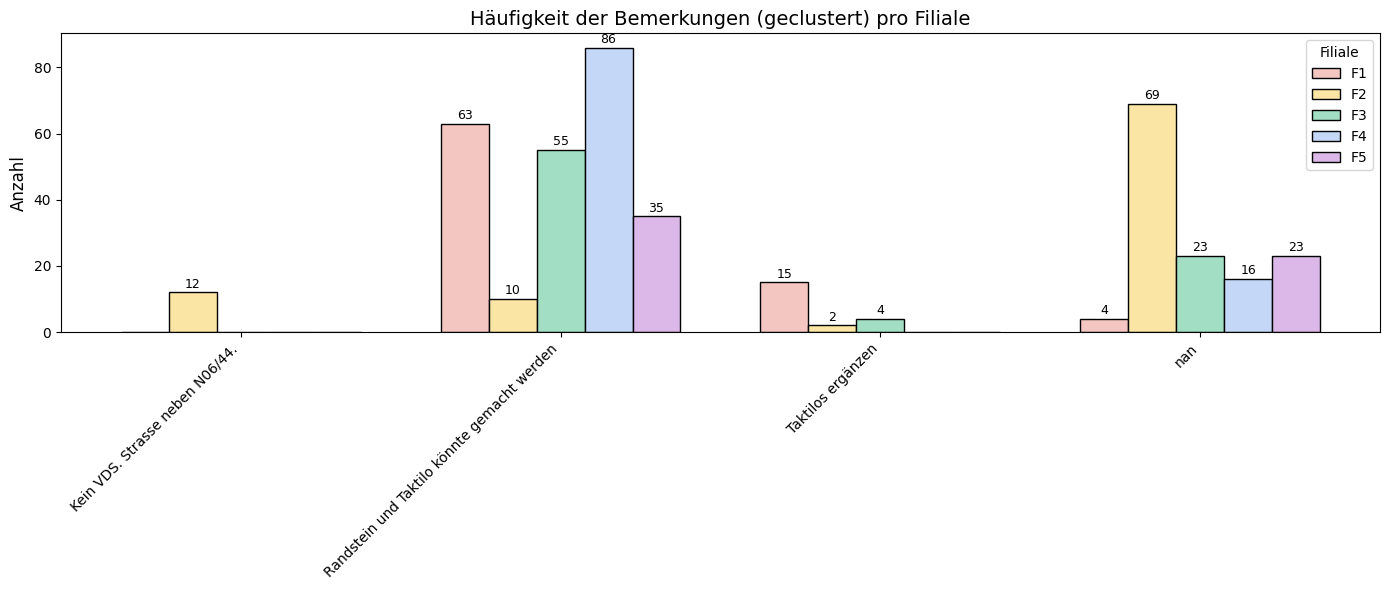

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import process  # ❗ notwendig für Fuzzy-Matching

# Einlesen
df = pd.read_csv("ASTRA-Bushaltestellen.csv", delimiter=';')

# Whitespace bereinigen
df["Bemerkungen"] = df["Bemerkungen"].astype(str).str.strip()
df["Filiale"] = df["Filiale"].astype(str).str.strip()

# Optional: nur sinnvolle Bemerkungen behalten (nicht leer)
df = df[df["Bemerkungen"] != ""]

# ❗ Schritt 1: Clustering ähnlicher Bemerkungen mit rapidfuzz
alle_bemerkungen = df["Bemerkungen"].unique()
clustered_labels = []
mapping = {}

for bemerkung in alle_bemerkungen:
    match = process.extractOne(bemerkung, clustered_labels, score_cutoff=90)
    if match:
        mapping[bemerkung] = match[0]
    else:
        mapping[bemerkung] = bemerkung
        clustered_labels.append(bemerkung)

# Neue Spalte mit Clusternamen
df["Bemerkung_cluster"] = df["Bemerkungen"].map(mapping)

# ❗ Schritt 2: Nur häufige Cluster behalten
häufige = df["Bemerkung_cluster"].value_counts()
relevante = häufige[häufige > 10].index
df = df[df["Bemerkung_cluster"].isin(relevante)]

# Gruppieren: wie oft kommt jede (geclusterte) Bemerkung pro Filiale vor?
gruppe = df.groupby(["Bemerkung_cluster", "Filiale"]).size().unstack(fill_value=0)

# Farben wie bisher
farben_gesamt = {
    "F1": "#F4C6C2",
    "F2": "#FAE5A4",
    "F3": "#A2DEC3",
    "F4": "#C4D7F7",
    "F5": "#DBB8E8"
}

# Plot-Einstellungen
bemerkungen = gruppe.index
filialen = gruppe.columns
x = np.arange(len(bemerkungen))  # Positionen der Bemerkungen auf der X-Achse
width = 0.15  # Balkenbreite

fig, ax = plt.subplots(figsize=(14, 6))

# Zeichne einen Balken pro Filiale nebeneinander
for i, filiale in enumerate(filialen):
    werte = gruppe[filiale]
    ax.bar(x + i * width, werte, width=width, label=filiale,
           color=farben_gesamt.get(filiale, "gray"), edgecolor="black")

    # ❗ Anzahl über Balken anzeigen
    for j, val in enumerate(werte):
        if val > 0:
            ax.text(x[j] + i * width, val + 0.5, str(val),
                    ha='center', va='bottom', fontsize=9)

# Achsen und Labels
ax.set_xticks(x + width * (len(filialen)-1)/2)
ax.set_xticklabels(bemerkungen, rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Anzahl", fontsize=12)
ax.set_title("Häufigkeit der Bemerkungen (geclustert) pro Filiale", fontsize=14)
ax.legend(title="Filiale")

plt.tight_layout()
plt.show()
